Here, we will try to predict prices, data has been explored already 

Dependencies :

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import yeojohnson
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import shapiro
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso,RidgeCV, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    ExtraTreesRegressor,
    BaggingRegressor,
    AdaBoostRegressor
)
from sklearn.ensemble import VotingRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('laptopData.csv')
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
print(df.shape)

(1273, 12)


Column Selector

In [3]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.columns = cols
    def fit(self, X, y=None):
        return self 
    def transform(self, X, y=None):
        X = X[self.columns]
        return X 
    def fit_transform(self, X, y = None):
        return self.transform(X)
        

Fixing data type :

In [4]:
class DataTypeFixer(BaseEstimator, TransformerMixin):
    def __init__(self, cols =None):
        self.cols = cols 
    def fit(self, X , y=None):
        return self 
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.cols:
            if col == "Inches":
                X_copy['Inches']= pd.to_numeric(X_copy['Inches'], errors='coerce').astype('float32')
                X_copy['Inches']=X_copy['Inches'].fillna(X_copy['Inches'].mean())
                X_copy['Inches']=X_copy['Inches'].apply(lambda x : float(x/2.54) if x > 17.5 else x)
            elif col == "Ram" :
                X_copy['Ram']= pd.to_numeric(X_copy['Ram'].str.replace('GB','').str.strip(), errors='coerce')
                X_copy['Ram']= X_copy['Ram'].fillna(X_copy['Ram'].mean()).astype('int32')
            elif col == "Weight":
                X_copy['Weight']= pd.to_numeric(X_copy['Weight'].str.replace('kg','').str.strip(),errors='coerce').astype('float32')
                X_copy['Weight'].fillna(X_copy['Weight'].mean(), inplace=True)
        return X_copy
    def fit_transform(self, X, y = None):
        return self.transform(X)


Feature Extraction

In [5]:
class FeatureExtract(BaseEstimator, TransformerMixin):
    def __init__(self, cols =None):
        self.cols = cols 
    def fit(self, X , y=None):
        return self 
    
    def extract_memory_feat(self, df):
        import re
        import numpy as np
        # Helper function to extract storage sizes
        def parse_storage(mem_str):
            ssd = hdd = flash = 0
            if not isinstance(mem_str, str):
                return ssd, hdd, flash
            # Replace TB with 1000GB for easier parsing
            mem_str = mem_str.replace('TB', '000GB')
            # Find all (size, type) pairs
            matches = re.findall(r'(\d+)GB\s*(SSD|HDD|Flash|Flash Storage)', mem_str)
            for size, stype in matches:
                size = int(size)
                if 'SSD' in stype:
                    ssd += size
                elif 'HDD' in stype:
                    hdd += size
                elif 'Flash' in stype:
                    flash += size
            return ssd, hdd, flash
        
        df['SSD'], df['HDD'], df['Flash'] = zip(*df['Memory'].map(parse_storage))
        return df
    
    # ...existing code for other extractors...
    def fetch_processor(self, text):
        if text in ['Intel Core i7', 'Intel Core i5', 'Intel Core i3']:
            return text
        elif isinstance(text, str) and text.split()[0] == 'Intel':
            return 'Other Intel Processor'
        else:
            return 'AMD Processor'
    
    def extract_cpu_feat(self, df):
        cpu_speed_pattern = r'\b\d+(?:\.\d+)?(?:GHz|Hz)\b'
        df['CPU speed']= pd.to_numeric(df['Cpu'].str.findall(cpu_speed_pattern).str.get(0).str.split('G').str.get(0), errors='coerce')
        # Ensure column is string type before applying split
        df['Cpu'] = df['Cpu'].astype(str)
        df['Cpu Name'] = df['Cpu'].apply(lambda x: " ".join(x.split()[0:3]) if isinstance(x, str) else "Unknown")
        df['CPU type'] = df['Cpu Name'].apply(self.fetch_processor)
        df.drop(columns=[ 'Cpu Name'], inplace= True)
        return df 

    def extract_resolution_feat(self,df):
        pattern = r'(\d{3,4}x\d{2,4})'
        res = df['ScreenResolution'].str.extract(pattern)
        res_splt = res[0].str.split('x', n=1, expand=True)
        res_splt.columns = ["X res", "Y res"]
        df["X res"]= pd.to_numeric(res_splt['X res'], errors='coerce')
        df["X res"]= df["X res"].fillna(df["X res"].mean()).astype('int32')
        df["Y res"]= pd.to_numeric(res_splt['Y res'], errors='coerce')
        df["Y res"]= df["Y res"].fillna(df["Y res"].mean()).astype('int32')
        df['IPS']= df['ScreenResolution'].apply(lambda x : 1 if 'IPS' in x else 0)
        df['Touchscreen']= df['ScreenResolution'].apply(lambda x : 1 if 'Touchscreen' in x else 0)
        df['PPI']= (np.sqrt((df['X res']**2)+(df['Y res']**2))/df['Inches'])
        df.drop(columns=['X res', 'Y res'], inplace=True)
        return df 

    def fetch_OS(self , text):
        if text in ['macOS', 'Mac OS X']:
            return "Mac"
        elif 'Windows' in text :
            return 'Windows'
        else :
            return "Others"
     
    def extract_OS(self, df):
        df["Operating System"]= df['OpSys'].apply(self.fetch_OS)
        return df 
    
    def extract_gpu(self , df):
        df['Gpu'] = df['Gpu'].apply(lambda x: x.split()[0] if isinstance(x, str) else "Unknown")
        return df
    
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.cols :
            if col == "Gpu":
                X_copy = self.extract_gpu(X_copy)
            elif col == "Memory":
                X_copy = self.extract_memory_feat(X_copy)
            elif col == "OpSys":
                X_copy = self.extract_OS(X_copy)
            elif col == "ScreenResolution":
                X_copy = self.extract_resolution_feat(X_copy)
            elif col == "Cpu":
                X_copy = self.extract_cpu_feat(X_copy)
        return X_copy

    def fit_transform(self, X, y = None):
        return self.transform(X)


Skew Fixer :

In [6]:
class SkewFixer(BaseEstimator, TransformerMixin):
    def __init__(self, cols =None, skew_threshold_left = -1, skew_threshold_right = 1):
        self.cols = cols 
        self.skew_threshold_left = skew_threshold_left 
        self.skew_threshold_right = skew_threshold_right
        self.skewed = []
    def fit(self, X , y=None):
        if self.cols is None :
            self.cols = X.select_dtypes(include=[np.number]).columns
        for col in self.cols:
            sk = X[col].skew()
            if sk > self.skew_threshold_right or sk < self.skew_threshold_left:
                self.skewed.append(col)

        return self ; 

        
    def transform(self, X, y=None):
        X_copy = X.copy()
        for col in self.skewed :
            X_copy[col], _ = yeojohnson(X_copy[col])
        return X_copy

        
    def fit_transform(self, X, y = None):
        return self.transform(X)


Company grouping :

In [7]:
# Merge sub-brands
df['Company'] = df['Company'].replace({'Vero': 'Acer'})

# Group companies with < 5 entries into 'Other'
company_counts = df['Company'].value_counts()
rare_companies = company_counts[company_counts < 5].index
df['Company'] = df['Company'].replace(rare_companies, 'Other')

Scaling :


In [8]:
class Scaler(BaseEstimator, TransformerMixin):
    def __init__(self, cols ):
        self.cols = cols
        self.scalers={} 
    
    def fit(self , X , y=None):
        for col in self.cols :
            stat , p = shapiro(X[col])
            if p > 0.05:
                scaler = StandardScaler()
            else :
                scaler = MinMaxScaler()
            scaler.fit(X[[col]])  # <-- Ensure DataFrame input
            self.scalers[col]=scaler 
        return self 
    
    def transform(self , X , y=None):
        X_copy = X.copy()
        for col in self.cols :
            X_copy[col]= self.scalers[col].transform(X_copy[[col]]).flatten()  # <-- Ensure DataFrame input
        return X_copy
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)


One hot Encoding the categorical columns :

In [9]:
class OneHot(BaseEstimator, TransformerMixin):
    def __init__(self, cols):
        self.cols = cols
        self.encoder = None 
        self.columnNames = None

    def fit(self , X , y=None):
        self.encoder = OneHotEncoder(sparse_output=False, drop='first')
        self.encoder.fit(X[self.cols])
        self.column_names = self.encoder.get_feature_names_out(self.cols)
        return self
    
    def transform(self , X , y=None):
        X_copy = X.copy()
        encoded = self.encoder.transform(X_copy[self.cols])
        encodedDF = pd.DataFrame(encoded, columns=self.column_names, index=X_copy.index)
        X_copy.drop(columns=self.cols, inplace=True)

        X_copy= pd.concat([X_copy, encodedDF], axis=1)

        return X_copy
    
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)


Dropper :

In [10]:
class DropColumnsTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, cols=None):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.cols is None:
            return X
        else:
            return X.drop(self.cols,axis=1)
       
    def fit_transform(self, X, y = None):
        self.fit(X, y)
        return self.transform(X)

In [11]:
class Full_pipeline:
    def __init__(self):
        self.allcols= ['Company', 'TypeName', 'Inches', 'ScreenResolution', 'Cpu', 'Ram',
                         'Memory', 'Gpu', 'OpSys', 'Weight']
        
        # Remove 'Gpu' from drop_cols to avoid KeyError
        self.drop_cols = ['ScreenResolution', 'Cpu', 'Memory', 'OpSys', 'Inches']
        
        self.encode_cols = ['TypeName', 'Company', 'CPU type', 'Gpu', "Operating System"]
        scaling_features = [
            'Inches',
            'Weight',
            'Ram',
            'PPI',
            'HDD',
            'SSD',
            'Flash',
            'CPU speed']
        
        self.full_pipeline= Pipeline([
            ('Column selector', ColumnSelector(cols=self.allcols)),
            ("fix", DataTypeFixer(cols=['Inches', 'Weight', 'Ram'])),
            ("Extract", FeatureExtract(cols=['Gpu', 'Cpu', 'Memory', 'ScreenResolution','OpSys'])),
            ("fix skew",SkewFixer(cols=['PPI', 'Weight', 'Ram','HDD', 'SSD',"Flash",'CPU speed' ])),
            ('onehot', OneHot(cols=self.encode_cols)),
            ("scale", Scaler(cols=scaling_features )),
            ('dropper', DropColumnsTransformer(cols=self.drop_cols))
        ])
        
        self.y_pipeline = Pipeline([
            ('selector', ColumnSelector(cols=['Price'])),
            ('power_transformation', SkewFixer(cols=['Price'])),
            ('scaling', Scaler(cols=['Price']))
        ])
    
    def fit_transform(self, X_train, y_train):
        X_train = self.full_pipeline.fit_transform(X_train)
        y_train = self.y_pipeline.fit_transform(y_train)
        return X_train, y_train
    
    def transform(self, X_test, y_test):
        X_test = self.full_pipeline.transform(X_test)
        y_test = self.y_pipeline.transform(y_test)
        return X_test, y_test

Now we split and preprocess the data !!

In [12]:
X = df.drop(columns=['Price'])
Y_copy = df['Price'].copy()
Y_copy = pd.DataFrame(Y_copy)
Y= df['Price']
Y = pd.DataFrame(Y)

In [13]:
# Show sample Memory values before feature extraction
full_pipeline1 = Full_pipeline()
X , Y = full_pipeline1.fit_transform(X, Y)
X_train_pre, X_test_pre, y_train_pre, y_test_pre = train_test_split(X, Y, test_size=0.15, random_state=42)
X_train_pre2, X_test_pre2, y_train_pre2, y_test_pre2 = train_test_split(X, Y_copy, test_size=0.15, random_state=42)
# Show SSD, HDD, Flash after feature extraction
print(X_train_pre[['SSD', 'HDD', 'Flash']].head(10))

           SSD   HDD    Flash
950   0.007812  0.00  0.00000
1121  0.250000  0.00  0.00000
1292  0.000000  0.25  0.00000
1247  0.250000  0.50  0.00000
306   0.250000  0.00  0.00000
838   0.000000  0.00  0.03125
863   0.000000  0.50  0.00000
1229  0.125000  0.50  0.00000
1029  0.250000  0.00  0.00000
361   0.250000  0.00  0.00000


In [16]:
# Save as CSV (recommended for DataFrames)
X_test_pre2.to_csv('X_test_pre.csv', index=False)
y_test_pre2.to_csv('y_test_pre.csv', index=False)


In [14]:
print(X_train_pre.describe())
# Save as CSV (recommended for DataFrames)
X_train_pre2.to_csv('X_train_pre.csv', index=False)
y_train_pre2.to_csv('y_train_pre.csv', index=False)


               Ram       Weight    CPU speed          SSD          HDD  \
count  1082.000000  1082.000000  1082.000000  1082.000000  1082.000000   
mean      0.119194     0.187233     0.518847     0.178424     0.205928   
std       0.090614     0.073041     0.187059     0.183263     0.257735   
min       0.000000     0.062145     0.000000     0.000000     0.000000   
25%       0.047619     0.138723     0.407407     0.000000     0.000000   
50%       0.111111     0.183769     0.592593     0.150391     0.000000   
75%       0.111111     0.207869     0.666667     0.250000     0.500000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

             Flash          IPS  Touchscreen          PPI  TypeName_Gaming  \
count  1082.000000  1082.000000  1082.000000  1082.000000      1082.000000   
mean      0.009993     0.284658     0.144177     0.214327         0.160813   
std       0.064361     0.451460     0.351432     0.165118         0.367529   
min       0.000000   

Data is cleaned , Now Need to make the models 

In [109]:
models = [
    LinearRegression(),
    Ridge(random_state=ord("S")),
    Lasso(random_state=ord("S")),
    ElasticNet(random_state=ord("S")),
    DecisionTreeRegressor(random_state=ord("S")),
    RandomForestRegressor(random_state=ord("S")),
    GradientBoostingRegressor(random_state=ord("S")),
    XGBRegressor(random_state=ord("S")),
    ExtraTreesRegressor(random_state=ord("S")),
    BaggingRegressor(random_state=ord("S")),
    AdaBoostRegressor(random_state=ord("S")),
    CatBoostRegressor(random_state=ord("S"),verbose=False),
    SVR(),
    KNeighborsRegressor()
]

In [110]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.array(y_true).ravel()  # flatten to 1-D
    y_pred = np.array(y_pred).ravel()
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

In [111]:
def evaluate_models(models, X_train, y_train, X_test, y_test, cv):
    results = []

    for model in models:
        # Cross-validation scores
        scores = cross_validate(model, X_train, y_train, cv=cv,scoring=['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'],return_train_score=True)
        
        
        mean_train_mae = -np.mean(scores['train_neg_mean_absolute_error'])
        mean_train_rmse = np.sqrt(-np.mean(scores['train_neg_mean_squared_error']))
        mean_train_r2 = np.mean(scores['train_r2'])
        
        
        model.fit(X_train, y_train)
        test_preds = model.predict(X_test)
        
        test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
        test_mae = mean_absolute_error(y_test, test_preds)
        test_r2 = r2_score(y_test, test_preds)
        test_mape = mean_absolute_percentage_error(y_test, test_preds)

        
        train_preds = model.predict(X_train)
        train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))
        train_mae = mean_absolute_error(y_train, train_preds)
        train_mape = mean_absolute_percentage_error(y_train, train_preds)
        
        # Store results
        results_dict = {
            'Algorithm': model.__class__.__name__,
            'Train Score': mean_train_r2,
            'Test Score': test_r2,
            'Train MAE': mean_train_mae,
            'Test MAE': test_mae,
            'Train RMSE': train_rmse,
            'Test RMSE': test_rmse,
            'Train MSE': mean_train_rmse,
            'Test MSE': test_rmse,
            'Train MAPE':train_mape,
            'Test MAPE' :test_mape
        }
        results.append(results_dict)

    results_df = pd.DataFrame(results)
    results_df.set_index('Algorithm', inplace=True)
    results_df = results_df.sort_values(by='Test Score', ascending=False)

    return results_df

In [112]:
results1 = evaluate_models(models , X_train_pre, y_train_pre, X_test_pre, y_test_pre,8)
results2 = evaluate_models(models , X_train_pre2, y_train_pre2, X_test_pre2, y_test_pre2,8)

In [113]:
results1

,Train Score,Test Score,Train MAE,Test MAE,Train RMSE,Test RMSE,Train MSE,Test MSE,Train MAPE,Test MAPE
Algorithm,,,,,,,,,,
CatBoostRegressor,0.971309,0.837766,0.014315,0.029394,0.020993,0.047281,0.020021,0.047281,14.382107,20.189999
GradientBoostingRegressor,0.903179,0.825362,0.026795,0.031107,0.036807,0.049055,0.036772,0.049055,25.537444,22.752857
ExtraTreesRegressor,0.997788,0.816366,0.001020,0.029785,0.005855,0.050303,0.005556,0.050303,0.765178,19.934889
RandomForestRegressor,0.972976,0.804363,0.012371,0.031423,0.019111,0.051921,0.019421,0.051921,9.310760,21.813437
XGBRegressor,0.993422,0.801536,0.005857,0.031143,0.011181,0.052295,0.009581,0.052295,6.981414,21.320493
BaggingRegressor,0.967388,0.793936,0.013182,0.032344,0.021529,0.053287,0.021351,0.053287,10.182393,22.325895
LinearRegression,0.764724,0.721478,0.040479,0.041091,0.057612,0.061951,0.057362,0.061951,38.747145,32.919634
Ridge,0.762552,0.721433,0.040588,0.040881,0.057811,0.061956,0.057626,0.061956,38.365434,32.084739
DecisionTreeRegressor,0.997788,0.716423,0.001020,0.039967,0.005855,0.062510,0.005556,0.062510,0.765178,26.232451


Train score of Extra tree is remarkable , but has huge overfitting as it does much worse in the training set, but still , it has  a fairly good prediction.


In [114]:
results2

,Train Score,Test Score,Train MAE,Test MAE,Train RMSE,Test RMSE,Train MSE,Test MSE,Train MAPE,Test MAPE
Algorithm,,,,,,,,,,
CatBoostRegressor,0.971309,0.837766,4519.008034,9279.243670,6627.094776,14925.879828,6320.328094,14925.879828,9.286510,15.045164
GradientBoostingRegressor,0.903179,0.825165,8458.767443,9829.558013,11619.441864,15494.691281,11608.360867,15494.691281,16.062445,16.405194
ExtraTreesRegressor,0.997788,0.817102,322.373682,9417.582824,1848.297997,15847.957103,1754.087990,15847.957103,0.585308,15.143728
RandomForestRegressor,0.972674,0.805766,3925.038852,9855.589927,6074.567333,16331.732829,6164.849834,16331.732829,6.472397,15.969311
XGBRegressor,0.993244,0.799055,1875.897507,10006.631836,3506.393161,16611.478441,3064.021153,16611.478441,4.453734,16.109051
BaggingRegressor,0.967283,0.794879,4168.141246,10292.471781,6841.181422,16783.176123,6752.101454,16783.176123,7.231539,16.927424
Lasso,0.764720,0.721580,12775.131856,12961.376940,18187.210114,19553.264245,18108.285727,19553.264245,24.122217,22.287219
LinearRegression,0.764724,0.721478,12778.475118,12971.628846,18187.077413,19556.846778,18108.162967,19556.846778,24.145470,22.326807
Ridge,0.762552,0.721433,12813.048850,12905.612212,18249.891856,19558.427594,18191.452205,19558.427594,23.978624,21.917705


Gradient Boosting regressor seems to have the best generalization so far 

We will try voting and stacking to try to bring down the error , and try to tune the hyper parameters a bit 

Randomized Search CV :
It is used to tune the hyper parametres . Grid search CV tries out all possible combinations of hyper parameters , which is too costly , instead , we use a randomized search cv to fine tune the model by taking some n random samples of hyper parameters


In [115]:
gradient_boost_regressor = GradientBoostingRegressor()

params = {
    'n_estimators':np.arange(100, 1001, 50),
    'learning_rate': np.logspace(-3, 0 , 20), # 0.001 to 1
    'max_depth': np.arange(3,60) ,
    'min_samples_split': np.arange(2, 21),             # min samples to split
    'min_samples_leaf': np.arange(1, 21),              # min samples per leaf
    'subsample': np.linspace(0.5, 1.0, 6),              # stochastic boosting
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.8],  # feature sampling
    'loss': ['squared_error', 'huber'],

}

random_search = RandomizedSearchCV( estimator=gradient_boost_regressor, param_distributions=params, n_iter=50,scoring='neg_mean_absolute_error',cv=5, verbose=2, random_state=42, n_jobs=1 )

random_search.fit(X_train_pre2, y_train_pre2)

print("Best parameters found:", random_search.best_params_)
print("Best CV score:", -random_search.best_score_)  # negate if using neg_* scoring


Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END learning_rate=0.018329807108324356, loss=squared_error, max_depth=13, max_features=0.8, min_samples_leaf=11, min_samples_split=5, n_estimators=1000, subsample=1.0; total time=   2.1s
[CV] END learning_rate=0.018329807108324356, loss=squared_error, max_depth=13, max_features=0.8, min_samples_leaf=11, min_samples_split=5, n_estimators=1000, subsample=1.0; total time=   2.1s
[CV] END learning_rate=0.018329807108324356, loss=squared_error, max_depth=13, max_features=0.8, min_samples_leaf=11, min_samples_split=5, n_estimators=1000, subsample=1.0; total time=   3.4s
[CV] END learning_rate=0.018329807108324356, loss=squared_error, max_depth=13, max_features=0.8, min_samples_leaf=11, min_samples_split=5, n_estimators=1000, subsample=1.0; total time=   3.6s
[CV] END learning_rate=0.018329807108324356, loss=squared_error, max_depth=13, max_features=0.8, min_samples_leaf=11, min_samples_split=5, n_estimators=1000, subsample=1.

In [116]:
gradient_boost_regressor = random_search.best_estimator_

For catBoost

In [117]:
catboost = CatBoostRegressor(random_state=ord("S"), verbose=0)

# Reduced parameter search space
param_dist_cb = {
    'iterations': randint(500, 1000),    
    'depth': randint(3, 13),             
    'learning_rate': uniform(0.01, 1), 
    'l2_leaf_reg': uniform(1, 5),         
    'border_count': randint(32, 100),     
}


cb_random = RandomizedSearchCV(estimator=catboost, 
                               param_distributions=param_dist_cb, 
                               n_iter=20,  
                               cv=2,      
                               verbose=1, 
                               random_state=42, 
                               n_jobs=-1)   

cb_random.fit(X_train_pre2, y_train_pre2)
print("Best parameters found:", cb_random.best_params_)
print("Best CV score:", -cb_random.best_score_)  # negate if using neg_* scoring

catboost = cb_random.best_estimator_

Fitting 2 folds for each of 20 candidates, totalling 40 fits
Best parameters found: {'border_count': 91, 'depth': 9, 'iterations': 927, 'l2_leaf_reg': np.float64(3.475884550556351), 'learning_rate': np.float64(0.0443885211152184)}
Best CV score: -0.8079390816688752


For Random forest Regressor :

In [118]:
random_forest = RandomForestRegressor(random_state=42)

param_dist = {
    'n_estimators': np.arange(100, 1001, 100),
    'max_depth': [None] + list(np.arange(5, 51, 5)),
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': ['auto', 'sqrt', 'log2', 0.5, 0.8], 
    'bootstrap': [True, False] ## wether to sample with replacement
}

fr_random = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=param_dist,
    n_iter=50,
    scoring='neg_mean_absolute_error',  # or 'r2', 'neg_mean_squared_error'
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
fr_random.fit(X_train_pre2, y_train_pre2)
print("Best parameters found:", fr_random.best_params_)
print("Best CV score:", -fr_random.best_score_)  # negate if using neg_* scoring

random_forest = fr_random.best_estimator_



Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'n_estimators': np.int64(900), 'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(1), 'max_features': 0.8, 'max_depth': np.int64(25), 'bootstrap': True}
Best CV score: 10491.491991191315


Eval after hyper parameter tuning :

In [135]:
def eval_selected_models(model , X , y):
    

        
        y_pred = model.predict(X)
        mae = mean_absolute_error(y, y_pred)
        rmse = np.sqrt(mean_squared_error(y, y_pred))
        r2 = r2_score(y, y_pred)
        mape = mean_absolute_percentage_error(y, y_pred)
        return mae, rmse, r2, mape 
        

Voting regressor : takes multiple base models and outputs sither a simple or weighted average 

In [128]:
base_models = [
    ("gb", gradient_boost_regressor),
    ("cb", catboost),
    ("rf", random_forest)
]
w = [3 , 2, 1]

voting_reg = VotingRegressor(
    estimators=base_models,
    weights=w
)

Stacking regressor : takes the input of models as a parameter and feeds into another model to get an output

In [129]:
stack_reg = StackingRegressor(
    estimators=base_models,
    final_estimator=RidgeCV(),  # meta-model
    cv=5,                       # CV for generating meta-features
    passthrough=False           # if True, original features are also passed to meta-model
)

In [131]:
voting_reg.fit(X_train_pre2, y_train_pre2)
stack_reg.fit(X_train_pre2, y_train_pre2)

,estimators,"[('gb', ...), ('cb', ...), ...]"
,final_estimator,RidgeCV()
,cv,5
,n_jobs,None
,passthrough,False
,verbose,0
,loss,'squared_error'
,learning_rate,np.float64(0....7599703514611)
,n_estimators,np.int64(900)
,subsample,np.float64(1.0)
,criterion,'friedman_mse'


Let's see what we have :

In [137]:
#for gradient boosting 
gbr_train_mae , gbr_train_rmse, gbr_train_r2, gbr_train_mape = eval_selected_models(gradient_boost_regressor,X_train_pre2, y_train_pre2)
gbr_test_mae , gbr_test_rmse, gbr_test_r2, gbr_test_mape = eval_selected_models(gradient_boost_regressor, X_test_pre2, y_test_pre2)

#for catboost 
cat_train_mae , cat_train_rmse, cat_train_r2, cat_train_mape = eval_selected_models(catboost,X_train_pre2, y_train_pre2)
cat_test_mae , cat_test_rmse, cat_test_r2, cat_test_mape = eval_selected_models(catboost, X_test_pre2, y_test_pre2)

#for Random forest 
rf_train_mae , rf_train_rmse, rf_train_r2, rf_train_mape = eval_selected_models(random_forest,X_train_pre2, y_train_pre2)
rf_test_mae , rf_test_rmse, rf_test_r2, rf_test_mape = eval_selected_models(random_forest, X_test_pre2, y_test_pre2)

#for voting 
vt_train_mae , vt_train_rmse, vt_train_r2, vt_train_mape = eval_selected_models(voting_reg,X_train_pre2, y_train_pre2)
vt_test_mae , vt_test_rmse, vt_test_r2, vt_test_mape = eval_selected_models(voting_reg, X_test_pre2, y_test_pre2)

#for stackign 
st_train_mae , st_train_rmse, st_train_r2, st_train_mape = eval_selected_models(stack_reg,X_train_pre2, y_train_pre2)
st_test_mae , st_test_rmse, st_test_r2, st_test_mape = eval_selected_models(stack_reg, X_test_pre2, y_test_pre2)

results = pd.DataFrame({
    'Model': ['GradientBoostingRegressor', 'CatBoostRegressor', 'RandomForestRegressor',"VotingRegressor","Stacking Regressor"],

    'Train MAE': [gbr_train_mae, cat_train_mae, rf_train_mae, vt_train_mae, st_train_mae],
    'Test MAE': [gbr_test_mae, cat_test_mae, rf_test_mae, vt_test_mae, st_test_mae],
    'Train RMSE': [gbr_train_rmse, cat_train_rmse, rf_train_rmse, vt_train_rmse, st_train_rmse],
    'Test RMSE': [gbr_test_rmse, cat_test_rmse, rf_test_rmse, vt_test_rmse, st_test_rmse],
    'Train R²': [gbr_train_r2, cat_train_r2, rf_train_r2, vt_train_r2, st_train_r2],
    'Test R²': [gbr_test_r2, cat_test_r2, rf_test_r2, vt_test_r2, st_test_r2],
    'Train MAPE': [gbr_train_mape, cat_train_mape, rf_train_mape, vt_train_mape, st_train_mape],
    'Test MAPE': [gbr_test_mape, cat_test_mape, rf_test_mape, vt_test_mape, st_test_mape]
})


In [138]:
results

,Model,Train MAE,Test MAE,Train RMSE,Test RMSE,Train R²,Test R²,Train MAPE,Test MAPE
0,GradientBoostingRegressor,2573.758712,9581.023222,4545.179527,15700.171063,0.985196,0.820498,4.421102,15.352504
1,CatBoostRegressor,2958.991740,9465.940668,4258.547351,15558.110843,0.987004,0.823731,6.037528,15.127010
2,RandomForestRegressor,6068.161079,9949.272123,9430.537363,16569.413879,0.936268,0.800071,10.382621,16.110428
3,VotingRegressor,3043.930943,9262.653514,4686.446265,15329.994765,0.984261,0.828862,5.438076,14.747888
4,Stacking Regressor,3164.224378,9439.725816,4941.205496,15488.918383,0.982504,0.825296,5.458848,15.373764


Even though Voting is more accurate ,  Random regressor seems to be more generalized

Visualizing the performance of Random forest :

In [141]:

def plot_regression_performance(model, X_test, y_test, save_path=None):
    """
    Plots regression performance:
    1. Predicted vs Actual
    2. Residual Plot
    3. Error Distribution
    
    Also prints R², MAE, and RMSE.
    
    Parameters:
    - model: trained regression model
    - X_test: test features
    - y_test: test target (array, Series, or DataFrame)
    - save_path: optional path to save the figure
    """
    # Ensure y_test is 1D
    y_true = np.ravel(y_test)
    y_pred = model.predict(X_test)
    residuals = y_true - y_pred

    # Metrics
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # 1️⃣ Predicted vs Actual
    axes[0].scatter(y_true, y_pred, alpha=0.6)
    axes[0].plot([y_true.min(), y_true.max()],
                 [y_true.min(), y_true.max()],
                 'r--', lw=2)
    axes[0].set_xlabel("Actual")
    axes[0].set_ylabel("Predicted")
    axes[0].set_title(f"Predicted vs Actual\nR² = {r2:.2f}")

    # 2️⃣ Residual Plot
    axes[1].scatter(y_pred, residuals, alpha=0.6)
    axes[1].axhline(y=0, color='r', linestyle='--')
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Residuals")
    axes[1].set_title("Residual Plot")

    # 3️⃣ Error Distribution
    sns.histplot(residuals, kde=True, ax=axes[2])
    axes[2].set_xlabel("Error")
    axes[2].set_title("Error Distribution")

    plt.tight_layout()

    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()



R² Score: 0.8001
MAE: 9949.2721
RMSE: 16569.4139


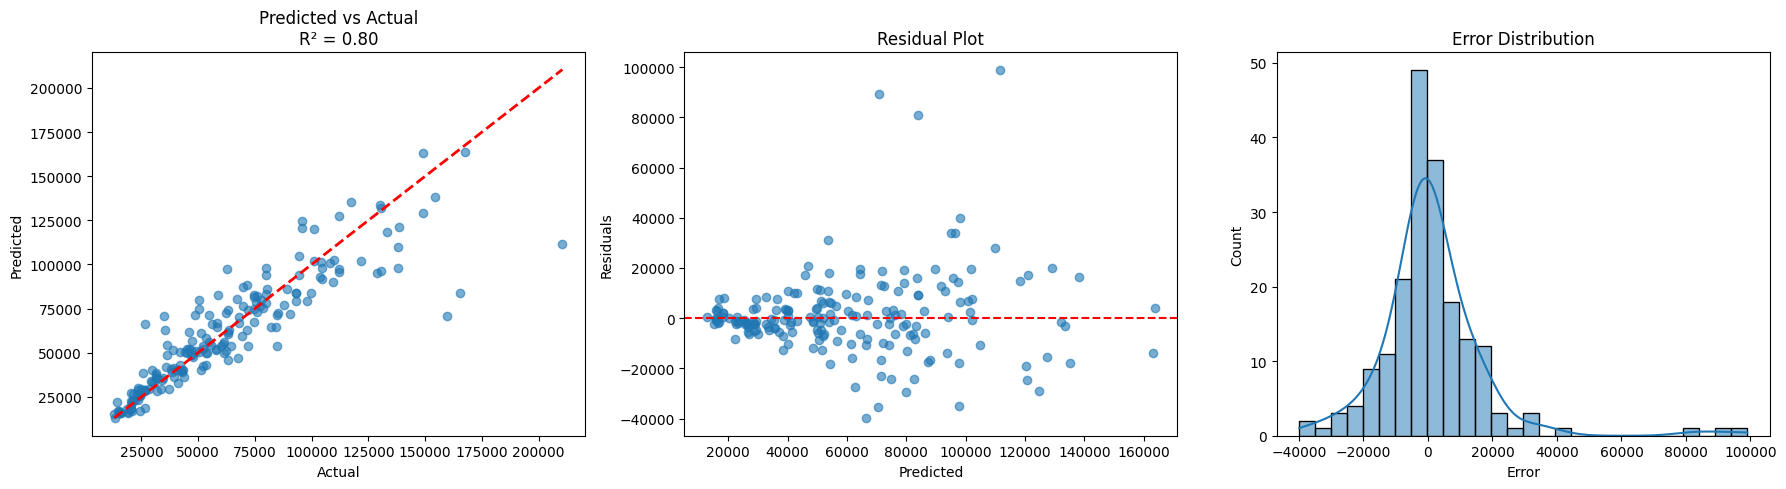

In [142]:
plot_regression_performance(random_forest, X_test_pre2, y_test_pre2)

Prediction Interface :

In [155]:
preds = random_forest.predict(X_train_pre2.head(5))
y_label = y_train_pre2.head(5)

In [153]:
preds

array([109983.27357563,  80288.8245506 ,  18262.25221077, 102273.24783396,
        99571.83916695])

In [156]:
y_label

,Price
950,119826.72
1121,90043.20
1292,20193.12
1247,123876.00
306,105228.00
